In [1]:
from urllib.request import urlopen
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

import os
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
figsize=(10, 6)

dfConso = pd.read_csv("../data/Table_conso.csv", sep=";", encoding="ansi")
dfIndiv = pd.read_csv("../data/Table_indiv.csv", sep=";", encoding="ansi")
dfCapiCA = pd.read_csv("../data/Table_capi_ca.csv", sep=";", encoding="ansi")
dfCarnetCA = pd.read_csv("../data/Table_carnet_ca_1.csv", sep=";", encoding="ansi")
dfIndivCA = pd.read_csv("../data/Table_indiv_ca.csv", sep=";", encoding="ansi")
dfIndnut = pd.read_csv("../data/Table_indnut.csv", sep=";", encoding="ansi")
dfMenage = pd.read_csv("../data/Table_menage_1.csv", sep=";", encoding="ansi")
dfRepas = pd.read_csv("../data/Table_repas.csv", sep=";", encoding="ansi")
dfNomenclature = pd.read_csv("../data/Nomenclature_3.csv", sep=";", encoding="ansi")
dfCorrespondance = pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi")
dfDataNames = pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (150,151,152,153,154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Table_capi_ca.csv
Table_carnet_ca_1.csv
Table_conso.csv
Table_indiv.csv
Table_indiv_ca.csv
Table_indnut.csv
Table_menage_1.csv
Table_repas.csv
correspondance_reponses.csv

In [2]:
dfCorrespondance.head(10)

,Libellé du codage,code,Signification
0,a5gglo,1,rural
1,a5gglo,2,2 000 à 20 000 hab.
2,a5gglo,3,20 000 à 100 000 hab.
3,a5gglo,4,> 100 000 hab
4,a5gglo,5,agglo paris
5,a9gglo,1,rural
6,a9gglo,2,2 000 à 5 000 hab.
7,a9gglo,3,5 000 à 10 000 hab.
8,a9gglo,4,10 000 à 20 000 hab.
9,a9gglo,5,20 000 à 50 000 hab.


In [3]:
dfDataNames.head(5)

,Nom de la variable,Type,Libellé du codage,Libellé de la variable
0,achapub,Numérique,pub,Demande à acheter des produits pour lesquels i...
1,achpub1,Numérique,achpub,A acheté Aliment 1 - Publicité
2,achpub2,Numérique,achpub,A acheté Aliment 2 - Publicité
3,achpub3,Numérique,achpub,A acheté Aliment 3 - Publicité
4,achpub4,Numérique,achpub,A acheté Aliment 4 - Publicité


In [4]:
dfDataCorrespondance = dfDataNames.merge(dfCorrespondance,left_on="Libellé du codage", right_on="Libellé du codage", how="inner")

In [67]:
def findCorrespondance(val, column):
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    return [findDescription(column) for column in columns]

In [6]:
marqCounts = dfConso\
    .groupby("libmarq")\
    .agg({"codal": "count"}, as_index=False)\
    .rename(columns={"codal": "count"})\
    .sort_values("count", ascending=False)
marqCounts

,count
libmarq,
x,305523
carrefour,8077
cristaline,6537
leader price,6528
auchan,6344
u,4622
champion,3530
coca cola,3453
dia,3297


In [7]:
print("Brands with more than one item: {} / {}".format(len(marqCounts[marqCounts["count"] > 1]), len(marqCounts)))

Brands with more than one item: 3885 / 7234


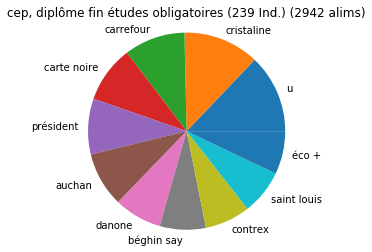

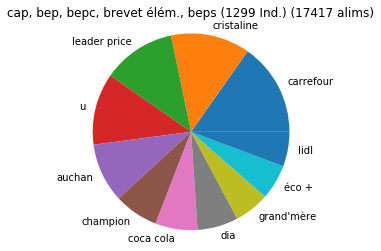

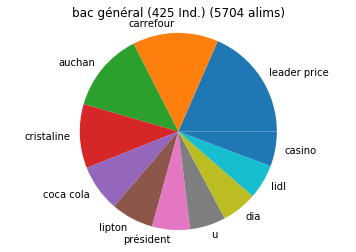

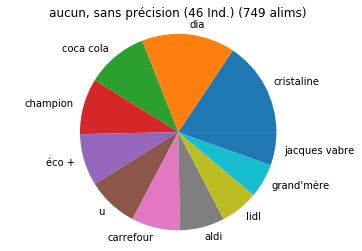

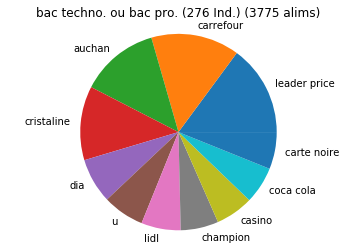

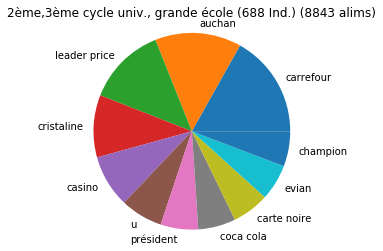

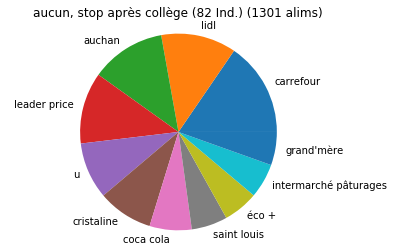

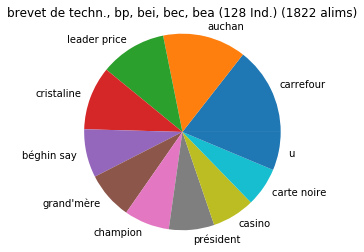

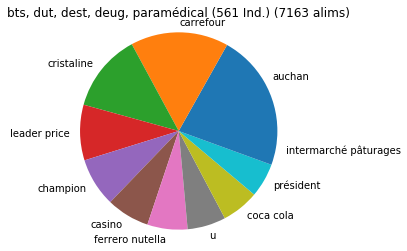

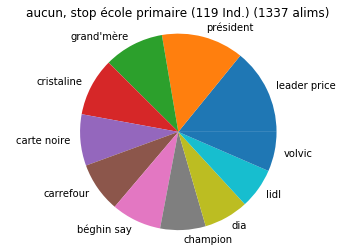

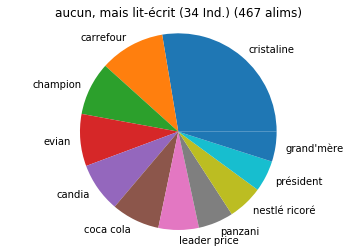

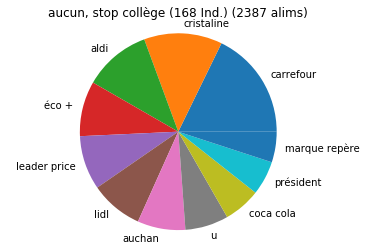

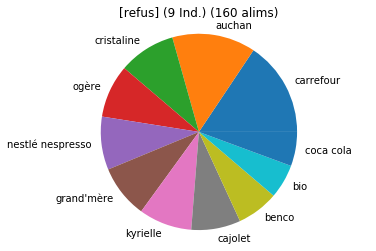

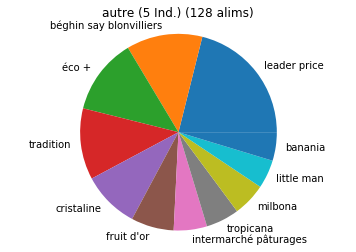

In [35]:
df = dfIndiv.merge(dfConso, left_on="nomen", right_on="nomen", how="inner")
dfBrands = df.groupby(["dip", "libmarq"], as_index=False).agg({"codal": "count"}).rename(columns={"codal": "count"})
dfBrands = dfBrands[dfBrands["count"] > 3]

diplomes = df["dip"].unique()

for diplome in diplomes:
    fig, ax = plt.subplots()
    dfBrandsDiplomes = dfBrands[dfBrands.dip == diplome].sort_values("count", ascending=False)
    ax.pie(x = dfBrandsDiplomes["count"][1:12], labels = dfBrandsDiplomes.libmarq[1:12])
    ax.axis("equal")
    ax.set_title("{} ({} Ind.) ({} alims)".format(findCorrespondance(diplome, "dip"), dfIndiv[dfIndiv["dip"] == diplome].shape[0], dfBrandsDiplomes["count"][1:12].sum()))
plt.show()

# Openfoodfacts

In [10]:
result = json.load(urlopen(OFF_API_PATH.format("brands")))

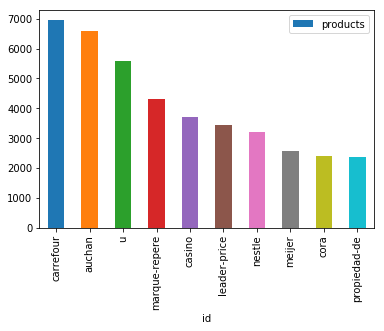

In [11]:
df = pd.DataFrame.from_records(result["tags"])
df.head(10).plot.bar(x="id", y="products")
plt.show()

In [12]:
def getOFFDataFrame(adress):
    result = json.load(urlopen(OFF_API_PATH.format(adress)))
    print("{} entries gathered".format(result["count"]))
    return pd.DataFrame(result["tags"])

In [13]:
labelsDf = getOFFDataFrame("labels")
labelsDf = labelsDf.sort_values("products", ascending=False)

10154 entries gathered


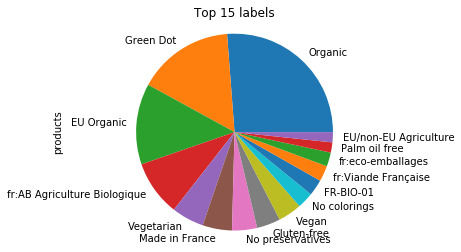

In [14]:
df = labelsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [15]:
countriesDf = getOFFDataFrame("countries")
countriesDf = countriesDf.sort_values("products", ascending=False)

244 entries gathered


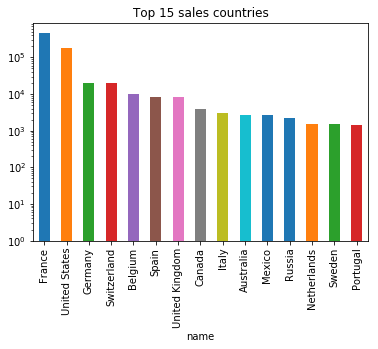

In [16]:
df = countriesDf.head(15)
df.plot.bar(x="name", y="products", legend=False, log=True)
plt.title("Top 15 sales countries")
plt.show()

In [17]:
ingredientsDf = getOFFDataFrame("nutrient-levels")
ingredientsDf = ingredientsDf.sort_values("products", ascending=False)

23 entries gathered


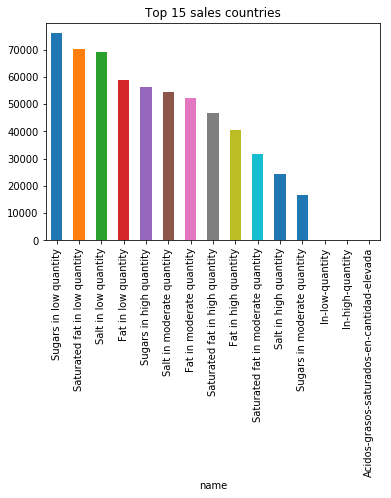

In [18]:
ingDf = ingredientsDf.head(15)
ingDf.plot.bar(x="name", y="products", legend=False)
plt.title("Top 15 sales countries")
plt.show()

In [19]:
result = json.load(urlopen(OFF_API_PATH.format("country/france/2")))
for k, v in result.items():
    try:
        print(k, len(v))
    except:
        print(k, v)

skip 20
count 450547
page 1
page_size 20
products 20


In [20]:
def findKey(data):
    for k, v in data.items():
        if isinstance(v, list):
            return k

def gatherOFFDataFramePages(adress, pages = None):
    result = json.load(urlopen(OFF_API_PATH.format(adress)))
    count = result["count"]
    key = findKey(result)
    df = pd.DataFrame(result[key])
    if "page" in result.keys():
        nbPages = (count - 1) // result["page_size"] + 1
        if pages != None:
            nbPages = np.min([nbPages, pages])
        for i in range(2, nbPages+1):
            currResult = json.load(urlopen(OFF_API_PATH.format(adress + "/" + str(i))))
            currDf = pd.DataFrame(currResult[key])
            df = df.append(currDf, sort=False)
            print(i, df["_id"].count())
    return df

In [21]:
franceDf = gatherOFFDataFramePages("country/france", 5)
franceDf[["_id", "product_name", "labels", "ingredients_text", "last_modified_t", "brands"]].head(100)

2 40
3 60
4 80
5 100


,_id,product_name,labels,ingredients_text,last_modified_t,brands
0,3036811362263,Doux Plaisir Potiron et Kiri,en:fsc,"eau, légumes 36% (potiron 18%, carotte, oignon...",1542907070,Liebig
1,3700048847632,Steak du boucher,NaN,NaN,1542907067,NaN
2,2745751478897,Barquettes chocolat noisette,NaN,NaN,1542907017,NaN
3,3540860006899,Bouteilles Cola,NaN,NaN,1542906998,NaN
4,3142952935010,Sauce bolognaise,NaN,NaN,1542906976,NaN
5,3281230000221,9 herbes,NaN,NaN,1542906702,NaN
6,20637217,Saucisses fumées,NaN,NaN,1542906697,NaN
7,3700968405684,Accras de morue,NaN,NaN,1542906696,NaN
8,3700048101932,Burger au veau,NaN,NaN,1542906651,NaN
9,2228533033267,Jambon de bayonne,NaN,NaN,1542906634,NaN


In [22]:
for x in franceDf.columns:
    print(x)

_id
_keywords
additives_debug_tags
additives_n
additives_old_n
additives_old_tags
additives_original_tags
additives_prev_n
additives_prev_original_tags
additives_prev_tags
additives_tags
allergens
allergens_from_ingredients
allergens_hierarchy
allergens_tags
amino_acids_prev_tags
amino_acids_tags
brands
brands_debug_tags
brands_tags
categories
categories_debug_tags
categories_hierarchy
categories_prev_hierarchy
categories_prev_tags
categories_tags
checkers_tags
cities_tags
code
codes_tags
complete
correctors_tags
countries
countries_debug_tags
countries_hierarchy
countries_tags
created_t
creator
debug_param_sorted_langs
debug_tags
editors
editors_tags
emb_codes
emb_codes_20141016
emb_codes_debug_tags
emb_codes_orig
emb_codes_tags
entry_dates_tags
expiration_date
expiration_date_debug_tags
fruits-vegetables-nuts_100g_estimate
generic_name
generic_name_fr
generic_name_fr_debug_tags
id
image_front_small_url
image_front_thumb_url
image_front_url
image_ingredients_small_url
image_ingredient

In [23]:
spark = SparkSession.builder.getOrCreate()
sqlContext = sqlContext = SQLContext(spark)

In [24]:
DATA_DIR = "../data/"
if os.path.exists(DATA_DIR+"openfoodfacts.parquet"):
    productsDf = spark.read.parquet(DATA_DIR + "openfoodfacts.parquet")
    #productsDf.show(2)
else:
    productsDf = spark.read.csv(DATA_DIR+'en.openfoodfacts.org.products.csv', header=True, sep="	") #load the dataset into a Spark dataframe
    #productsDf.show(2) #show the content (20 first rows)
    productsDf.write.parquet(DATA_DIR+"openfoodfacts.parquet", mode="overwrite") #save it in the Parquet format

for (k, v) in productsDf.dtypes:
    print("{: <20}:{}".format(k, v))

code                :string
url                 :string
creator             :string
created_t           :string
created_datetime    :string
last_modified_t     :string
last_modified_datetime:string
product_name        :string
generic_name        :string
quantity            :string
packaging           :string
packaging_tags      :string
brands              :string
brands_tags         :string
categories          :string
categories_tags     :string
categories_en       :string
origins             :string
origins_tags        :string
manufacturing_places:string
manufacturing_places_tags:string
labels              :string
labels_tags         :string
labels_en           :string
emb_codes           :string
emb_codes_tags      :string
first_packaging_code_geo:string
cities              :string
cities_tags         :string
purchase_places     :string
stores              :string
countries           :string
countries_tags      :string
countries_en        :string
ingredients_text    :string
allergens

In [25]:
dfConsoAll = dfConso.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")

In [26]:
def plotBar(table, idx, col, x):
    consos = table[[col, idx, x]].groupby([idx, col]).count().unstack(level=1)[x]
    consos = consos.swapaxes(0,1)
    consos = consos / consos.sum(axis=0)
    consos = consos.swapaxes(0,1)
    consos.index = mapCorrespondances(consos.index, idx)
    consos.columns = mapCorrespondances(consos.columns, col)
    consos.plot.bar(stacked=True)
    plt.show()

def plotScatter(table, col1, col2):
    data = table[[col1, col2]].values
    plt.scatter(data[:,0], data[:,1])
    plt.show()
    
def getBinsFunc(x, nbins):
    xmin = np.min(x)
    xmax = np.max(x) * 1.01
    return lambda v: np.int16(nbins * (v - xmin) / (xmax - xmin)) * (xmax - xmin) + xmin
    
def plotScatterCateX(table, x, y, index, bins):
    consos = table[[x, y, index]]
    f = getBinsFunc(consos[y], bins)
    consos[y] = f(consos[y])
    plotBar(consos, x, y, index)
    

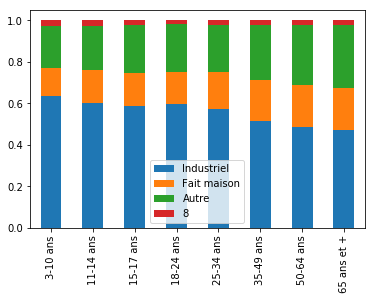

In [27]:
plotBar(dfConsoAll, "tage", "typal3", "numlig")

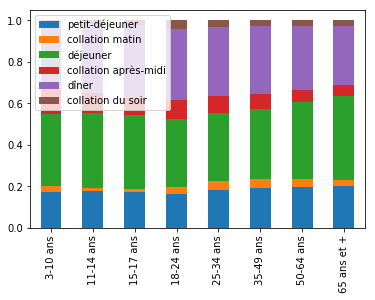

In [28]:
plotBar(dfConsoAll, "tage", "tyrep", "numlig")

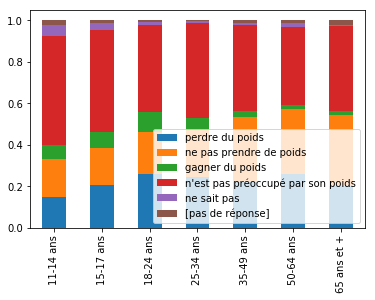

In [29]:
plotBar(dfIndiv, "tage", "essaipds", "nomen")

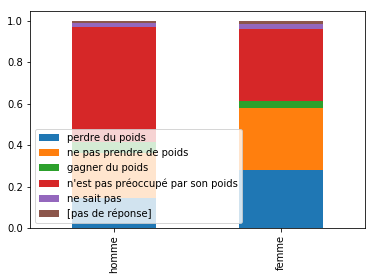

In [30]:
plotBar(dfIndiv, "sexe_ps", "essaipds", "nomen")

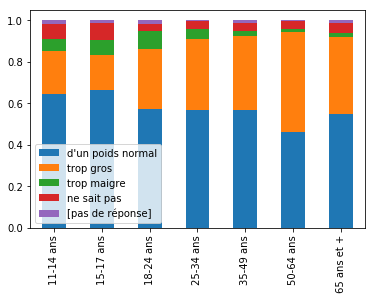

In [31]:
plotBar(dfIndiv, "tage", "opipoids", "nomen")

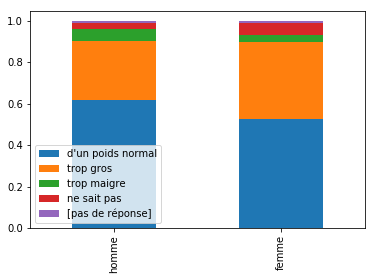

In [32]:
plotBar(dfIndiv, "sexe_ps", "opipoids", "nomen")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


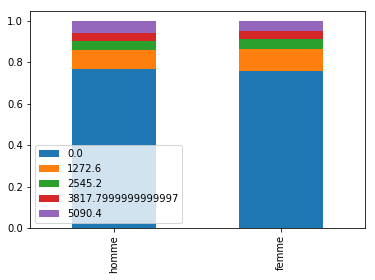

In [33]:
plotScatterCateX(dfIndiv, "sexe_ps", "modere_hebdo", "nomen", 5)

# Inference

In [37]:
from sklearn.decomposition import PCA

In [92]:
def plotPCAComponents(table, features, trainIndex = None, nbComps=4):
    # Train PCA
    data = table[features].values
    
    if trainIndex is None:
        trainIndex = np.ones(len(data), "bool")

    trainData = data[trainIndex]

    mu = np.mean(trainData, axis=0)
    sigma = np.std(trainData, axis=0)

    trainData = (trainData - mu) / sigma

    pca = PCA()
    pca.fit(trainData)
    
    #Show PCA first comps
    featuresNames = mapDescription(features)
    
    cumComponents = np.zeros(len(features))
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(nbComps):
        components = np.abs(pca.components_[i, :])
        ax.bar(featuresNames, components, bottom=cumComponents)
        cumComponents += components
    plt.xticks(fontsize=12, rotation=90)
    plt.show()

In [108]:
def plotMeanValues(table, features, className, mincount=50):
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, figsize=figsize)
    plt.show()

In [68]:
table = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
className = "tage"
samples = "nomen"
cateFeatures = []
numFeatures = np.array(["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)])
featuresNames = mapDescription(numFeatures)

data = table[numFeatures].values
labels = table[className].values

trainIndex = np.ones(len(data), "bool")
trainIndex[np.arange(int(len(data) * 0.8))] = False

trainData = data[trainIndex]
testData = data[~trainIndex]
trainLabels = labels[trainIndex]
testLabels = labels[~trainIndex]

mu = np.mean(trainData, axis=0)
sigma = np.std(trainData, axis=0)

trainData = (trainData - mu) / sigma
testData = (testData - mu) / sigma


pca = PCA()
pca.fit(trainData)

{'copy': True, 'iterated_power': 'auto', 'n_components': None, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}


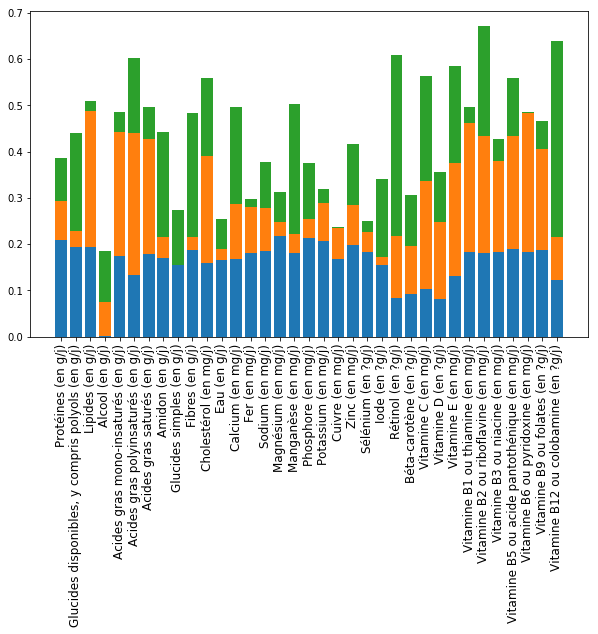

In [71]:
nbComps = 3
cumComponents = np.zeros(len(numFeatures))
fig, ax = plt.subplots(figsize=figsize)
for i in range(nbComps):
    components = np.abs(pca.components_[i, :])
    ax.bar(featuresNames, components, bottom=cumComponents)
    cumComponents += components
plt.xticks(fontsize=12, rotation=90)
plt.show()

In [142]:
indnutIndTable = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
columns = {col:col[:-2] for col in indnutIndTable.columns if col[-2:] == "_x"}
dropColumns = [col for col in indnutIndTable.columns if col[-2:] == "_y"]
indnutIndTable = indnutIndTable.rename(columns = columns).drop(columns= dropColumns)

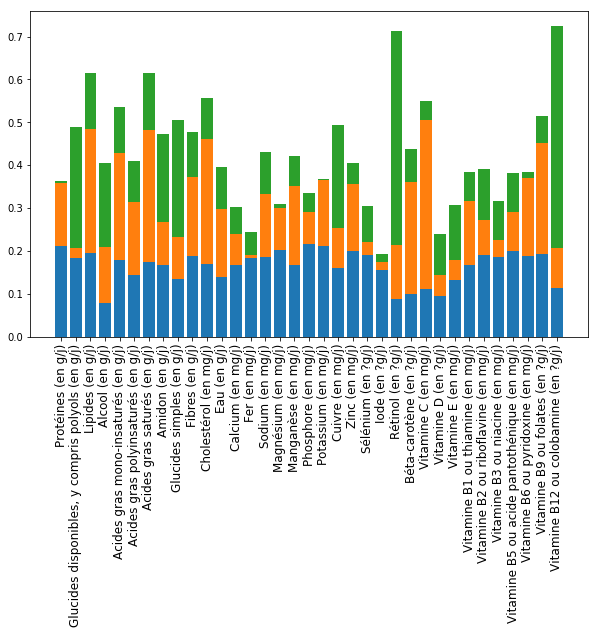

In [98]:
plotPCAComponents(indnutIndTable, numFeatures, nbComps=3)

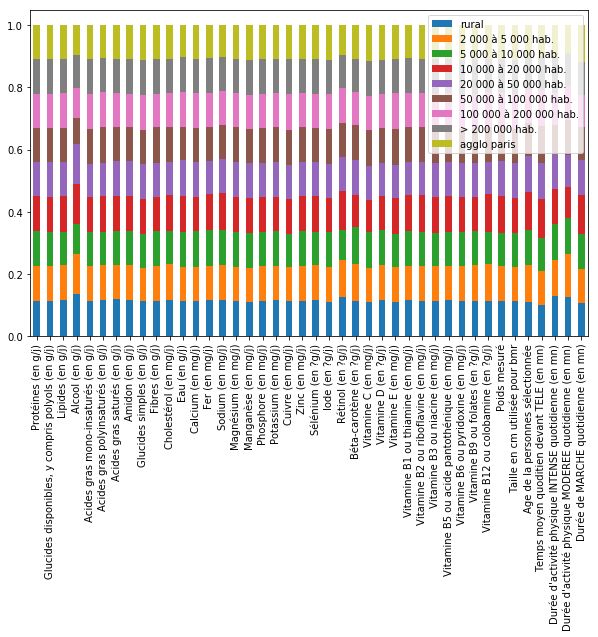

In [147]:
className = "agglo9"
samples = "nomen"
cateFeatures = []
numFeatures = ["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)] + ["poidsm", "taille", "v2_age", "tele", "intense_j", "modere_j", "marche_j"]
featuresNames = mapDescription(numFeatures)

table = indnutIndTable
means = table.groupby(className).mean()[numFeatures]
means.columns = featuresNames
means /= means.sum(axis=0)
means = means.swapaxes(0, 1)
means.columns = mapCorrespondances(means.columns, className)
means.plot.bar(stacked=True, figsize=figsize)
plt.show()

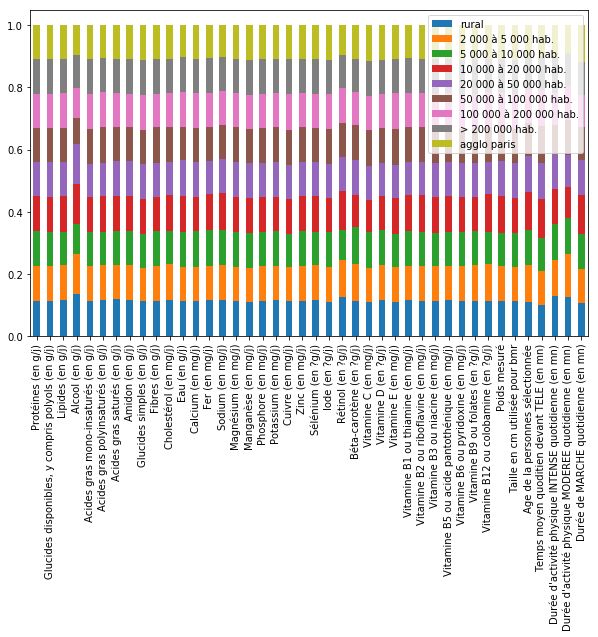

In [148]:
plotMeanValues(indnutIndTable, numFeatures, "agglo9")

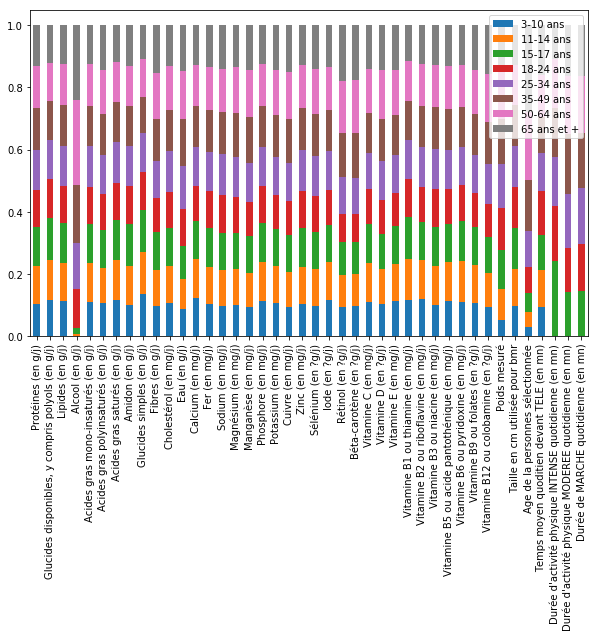

In [149]:
plotMeanValues(indnutIndTable, numFeatures, "tage")

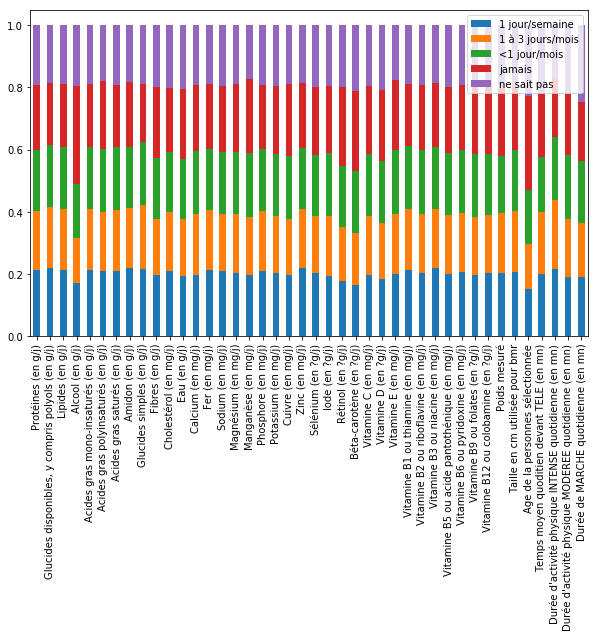

In [150]:
plotMeanValues(indnutIndTable, numFeatures, "fastfood")

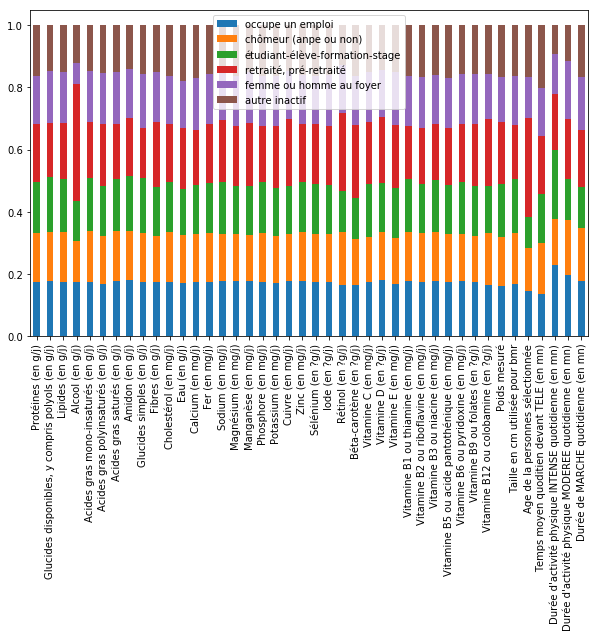

In [151]:
plotMeanValues(indnutIndTable, numFeatures, "situ_prof")

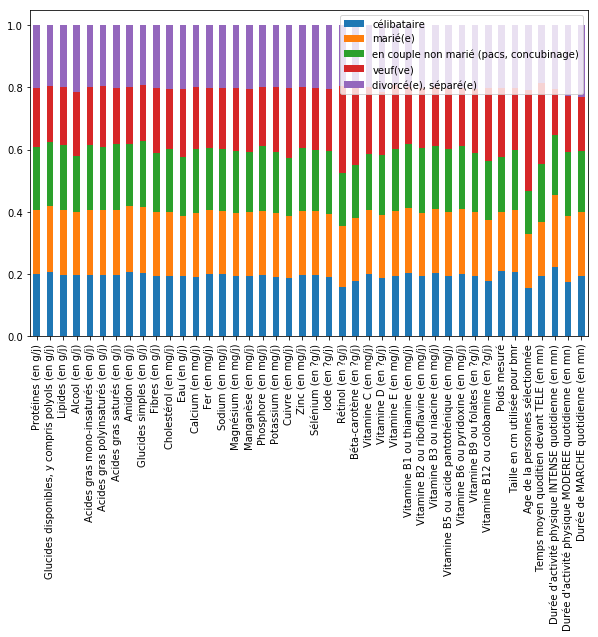

In [152]:
plotMeanValues(indnutIndTable, numFeatures, "situ_mat")

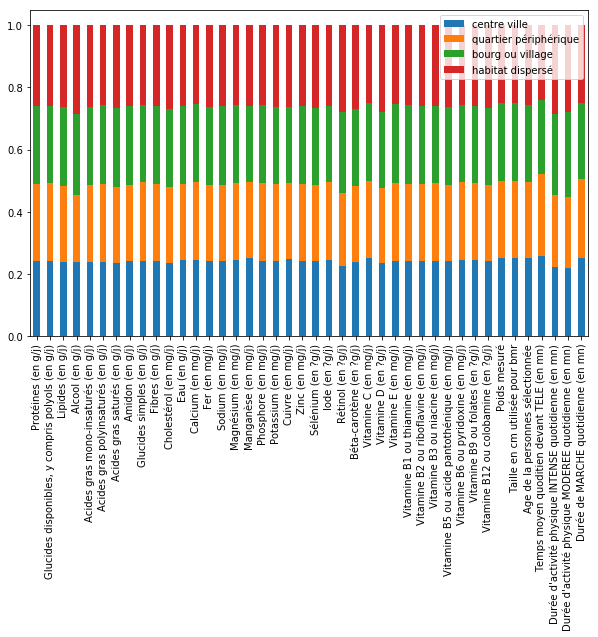

In [153]:
plotMeanValues(indnutIndTable, numFeatures, "loc_log")

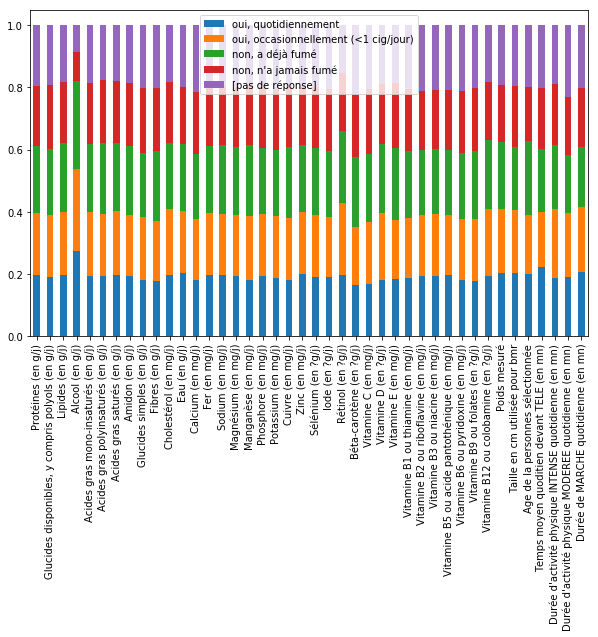

In [155]:
plotMeanValues(indnutIndTable, numFeatures, "fume")

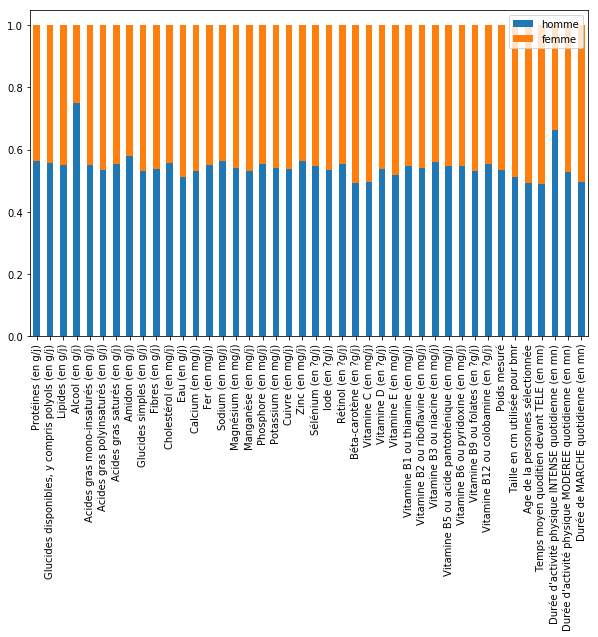

In [160]:
plotMeanValues(indnutIndTable, numFeatures, "sexe_ps")

In [145]:
for col in indnutIndTable.columns:
    print(col)

nomen
sexe_ps
ech
v2_age
aet
nutj4
nutj5
nutj6
nutj7
nutj8
nutj9
nutj10
nutj11
nutj12
nutj13
nutj14
nutj15
nutj16
nutj17
nutj18
nutj19
nutj20
nutj21
nutj22
nutj23
nutj24
nutj25
nutj26
nutj27
nutj28
nutj30
nutj31
nutj32
nutj33
nutj34
nutj35
nutj36
nutj37
nutj38
nutj39
sexeps
fqcantine
entrerep
colmata
distrib
distconf
distfruit
distsoli
fastfood
ffrepas
selassent
selassleg
selassfec
selassvp
selassvps
selassoeuf
enrich
lardcru
sauccru
boeufcru
chevcru
porccru
volcru
poiscru
oeufcru
shboeufcuis
boeufcuis
rotboeufcuis
foiecuis
veaucuis
porccuis
sauccuis
chevcuis
agncuis
cotagncuis
volcuis
intalim
intalinouv
infopub
infoprof
infointern
etiquetad
etiqingr
etiqnut
etiqport
etiqclnut
etiqclsant
bonalim
regimedj
poids12
poids12nsp
essaipds
contalim
contap
opipoids
voeupoids
nbgeneral
nbspecial
pdsmax
agepmax
agepmaxnsp
pdsmin
pdsminnsp
agepmin
agepminnsp
cyclepds
enceinte
allaite
enceinte12
menopaus
ths
fume
nbcigrjm
nbpipejm
nbcigrsm
nbpipesm
agefumem
nbcigrja
nbpipeja
nbcigrsa
nbpipesa
nbcig